In [1]:
import sys
sys.path.append("contrastive-regression/models/")
from linear_cr_bz import LinearCRBZ
import scanpy as sc

In [2]:
import pandas as pd

In [14]:
data = pd.read_csv("data/polyps/SuppTable2_PolypALL_merged.txt.gz",sep="\t",index_col=0)

In [15]:
data = data.T

In [16]:
meta = pd.read_csv("data/polyps/np_alexandria_meta_with_sss.csv",index_col=0 )

/scratch/snyquist/ipykernel_3148906/3066979459.py:1: DtypeWarning: Columns (6,10,11,16,17,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv("data/polyps/np_alexandria_meta_with_sss.csv",index_col=0 )


In [12]:
no_polyp_order = pd.read_csv("data/polyps/no_polyp_epithelial_pseudotime_order.csv",header=None, index_col=0)

In [17]:
no_polyp_cells = data.loc[no_polyp_order.index]

In [13]:
polyp_order = pd.read_csv("data/polyps/polyp_epithelial_pseudotime_order.csv",header=None, index_col=0)

In [18]:
polyp_cells = data.loc[polyp_order.index]

In [ ]:
# find variable genes

import anndata

In [ ]:
adata = anndata.AnnData(data.loc[list(no_polyp_order.index)+list(polyp_order.index)])

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


In [ ]:
adata.raw=adata

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=500)


In [7]:
# add genes from prior work
additional_genes = ["POSTN","PTHLH","IGJ","IGHA1","ALOX15","EPAS1","ZG16B","LYZ","STATH","MSMB","IGHG4","SCGB1A1","CST1","IGFBP3","SCGB3A1","CST4","EGLN3","CDH26","PSCA","SERPINB2","IGHA2","LYPD2","CCL26","CST2"]
adata.var.highly_variable[additional_genes] = True

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [36]:
adata.write_h5ad("data/polyps/processed_adata.h5ad")

In [8]:
adata=sc.read_h5ad("data/polyps/processed_adata.h5ad")

In [10]:
adata
background = adata[no_polyp_order.index].X
foreground = adata[polyp_order.index].X

In [ ]:
# lognormed data, top 500 variable genes, ordered by ints

In [37]:
#non polyp is foreground, polyp is background



In [48]:
import numpy as np
np.save( "data/polyps/no_polyp_lognorm_top500vargenes.npy",background)
np.save("data/polyps/polyp_lognorm_top500vargenes.npy",foreground)

In [9]:
import numpy as np
foreground = np.load("data/polyps/no_polyp_lognorm_top500vargenes.npy")
background = np.load("data/polyps/polyp_lognorm_top500vargenes.npy")

In [41]:
background.shape

(3898, 504)

In [17]:
st = time.time()
model = LinearCRBZ()
model.fit(foreground, background, no_polyp_order.to_numpy(),d=3,verbose=False,print_every=1000000)
preds = model.predict(foreground)
et=time.time()
print("time elapsed "+str(et-st))

time elapsed 661.9912612438202


In [35]:
from sklearn.metrics import r2_score
from scipy.stats import linregress

_, _, r2_contrastivereg, _, _ = linregress(no_polyp_order.to_numpy().squeeze(), preds)


In [36]:
import matplotlib.pyplot as plt
import matplotlib

In [33]:
font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

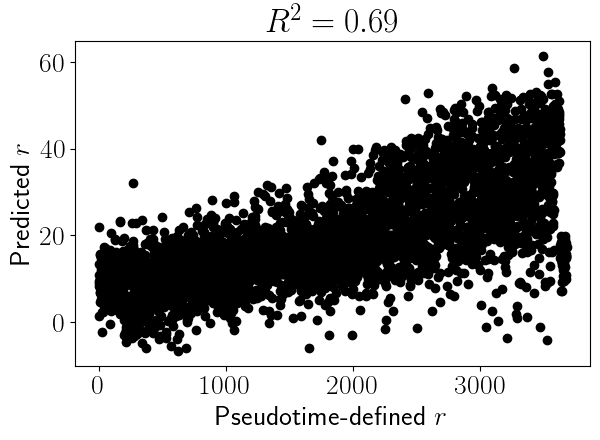

In [36]:
plt.scatter(no_polyp_order.to_numpy(),preds,c="black")
plt.xlabel(r"Pseudotime-defined $r$")
plt.ylabel(r"Predicted $r$")
plt.title(r"$R^2 = " + str(round(r2_contrastivereg, 2)) + "$")
plt.tight_layout()
plt.savefig("r_squared_nopolyp.pdf")
plt.savefig("r_squared_nopolyp.png")

In [ ]:
# try multiple numbers of dimensions
import os
n_dims = 10
for n_dims in [2,3,4,5,7,9,11,13,14]:
    model = LinearSSCR()
    model.fit(foreground, background, no_polyp_order.to_numpy(),d=n_dims,print_every=100)
    preds = model.predict(foreground)
    _, _, r2_contrastivereg, _, _ = linregress(no_polyp_order.to_numpy().squeeze(), preds)


    dirname = "dim"+str(n_dims)+"/"
    os.mkdir(dirname)
    plt.scatter(no_polyp_order.to_numpy(),preds,c="black")
    plt.xlabel(r"True $r$")
    plt.ylabel(r"Predicted $r$")
    plt.title(r"$R^2 = " + str(round(r2_contrastivereg, 2)) + "$")
    plt.tight_layout()
    plt.savefig(dirname+"rsquared.pdf")
    dims = ["Dim%d" % i for i in range(0,n_dims)]
    loading_w = pd.DataFrame(model.W, columns = adata.var_names, index = dims,dtype = "float")
    loading_w.to_csv(dirname+"W.csv")
    #latent_t = pd.DataFrame(model.t, columns = dims, index = asd_sample, dtype="float")
    #latent_t.to_csv(dirname+"t.csv")
    auxiliary_s = pd.DataFrame(model.S, columns = adata.var_names, index = dims, dtype="float")
    auxiliary_s.to_csv(dirname+"S.csv")
    betas = pd.DataFrame(data=model.beta)
    betas.to_csv(dirname+"beta.csv")

Step: 0               Log marginal lik.: -7159427584.0
Step: 100             Log marginal lik.: -1839090688.0
Step: 200             Log marginal lik.: -1050838720.0
Step: 300             Log marginal lik.: -757059200.0
Step: 400             Log marginal lik.: -598891392.0
Step: 500             Log marginal lik.: -498463424.0
Step: 600             Log marginal lik.: -428328288.0
Step: 700             Log marginal lik.: -376231776.0
Step: 800             Log marginal lik.: -335785184.0
Step: 900             Log marginal lik.: -303365280.0
Step: 1000            Log marginal lik.: -276682976.0
Step: 1100            Log marginal lik.: -254318224.0
Step: 1200            Log marginal lik.: -235232288.0
Step: 1300            Log marginal lik.: -218741984.0
Step: 1400            Log marginal lik.: -204309264.0
Step: 1500            Log marginal lik.: -191556480.0
Step: 1600            Log marginal lik.: -180192912.0
Step: 1700            Log marginal lik.: -169997680.0
Step: 1800            Log

Step: 15700           Log marginal lik.: 1292070.0
Step: 15800           Log marginal lik.: 1293084.0
Step: 15900           Log marginal lik.: 1294043.38
Step: 16000           Log marginal lik.: 1294951.38
Step: 16100           Log marginal lik.: 1295811.25
Step: 16200           Log marginal lik.: 1296624.0
Step: 16300           Log marginal lik.: 1297392.88
Step: 16400           Log marginal lik.: 1298119.5
Step: 16500           Log marginal lik.: 1298806.25
Step: 16600           Log marginal lik.: 1299455.25
Step: 16700           Log marginal lik.: 1300069.0
Step: 16800           Log marginal lik.: 1300648.0
Step: 16900           Log marginal lik.: 1301194.5
Step: 17000           Log marginal lik.: 1301710.25
Step: 17100           Log marginal lik.: 1302197.38
Step: 17200           Log marginal lik.: 1302656.0
Step: 17300           Log marginal lik.: 1303088.75
Step: 17400           Log marginal lik.: 1303495.75
Step: 17500           Log marginal lik.: 1303879.62
Step: 17600         

Step: 11600           Log marginal lik.: 1135438.0
Step: 11700           Log marginal lik.: 1153554.75
Step: 11800           Log marginal lik.: 1170131.75
Step: 11900           Log marginal lik.: 1185337.75
Step: 12000           Log marginal lik.: 1199315.75
Step: 12100           Log marginal lik.: 1212191.25
Step: 12200           Log marginal lik.: 1224074.12
Step: 12300           Log marginal lik.: 1235060.25
Step: 12400           Log marginal lik.: 1245233.0
Step: 12500           Log marginal lik.: 1254667.0
Step: 12600           Log marginal lik.: 1263427.25
Step: 12700           Log marginal lik.: 1271574.25
Step: 12800           Log marginal lik.: 1279158.25
Step: 12900           Log marginal lik.: 1286226.75
Step: 13000           Log marginal lik.: 1292822.12
Step: 13100           Log marginal lik.: 1298981.0
Step: 13200           Log marginal lik.: 1304738.0
Step: 13300           Log marginal lik.: 1310124.5
Step: 13400           Log marginal lik.: 1315167.0
Step: 13500        

In [54]:
# is the min beta similar
for n_dims in [2,3,4,5,7,9,10,11,13,14]:
    dirname = "dim"+str(n_dims)+"/"
    print("dim"+str(n_dims))
    loading_w = pd.read_csv(dirname+"W.csv",index_col=0)
    betas = pd.read_csv(dirname+"beta.csv",index_col=0)
    max_dim = "Dim"+ str(betas["0"].argmax())
    print(loading_w.loc[max_dim].sort_values())

dim2
BMX       -0.003511
RGS13     -0.003184
LRMP      -0.002317
PLCB2     -0.002052
CCDC129   -0.001731
             ...   
STATH      1.370089
MSMB       1.483295
S100A4     1.486222
BPIFA1     1.582396
BPIFB1     1.765916
Name: Dim0, Length: 504, dtype: float64
dim3
CLCA4            -0.010052
AC104024.1       -0.000426
AP000654.4       -0.000363
RP11-1299A16.3   -0.000246
CLEC17A          -0.000226
                    ...   
MTRNR2L1          1.224571
STATH             1.412773
BPIFA1            1.606660
MSMB              1.608337
BPIFB1            1.844332
Name: Dim1, Length: 504, dtype: float64
dim4
CEACAM5    -0.014345
CEACAM6    -0.006412
SAA2       -0.004293
MUC5AC     -0.002181
SPRR3      -0.001759
              ...   
ALOX15      0.983226
BPIFA1      1.378322
MTRNR2L1    1.596963
EPAS1       1.862047
STATH       2.056753
Name: Dim0, Length: 504, dtype: float64
dim5
KRT15     -0.320356
MUC5AC    -0.258696
TFF3      -0.252038
SPINK5    -0.171956
POSTN     -0.156444
            

In [38]:
dims = ["Dim%d" % i for i in range(0,3)]
loading_w = pd.DataFrame(model.W, columns = adata.var_names, index = dims,dtype = "float")
betas = pd.DataFrame(data=model.beta)

In [181]:
loading_w.to_csv("loadings_unscaled_d3.csv")

In [87]:
corr_genes=pd.read_csv("correlated_genes.txt")["genes"].values

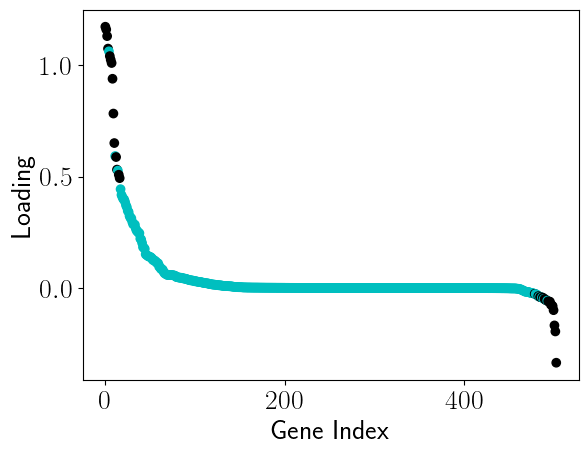

In [179]:
plt.scatter(list(range(0,504)),(loading_w.loc["Dim1"].sort_values(ascending =False)),c=["k" if i in corr_genes else "c" for i in loading_w.loc["Dim1"].sort_values(ascending =False).index]
)
plt.ylabel("Loading")
plt.xlabel("Gene Index")
plt.savefig("ranked_loading_plot.pdf",bbox_inches="tight")

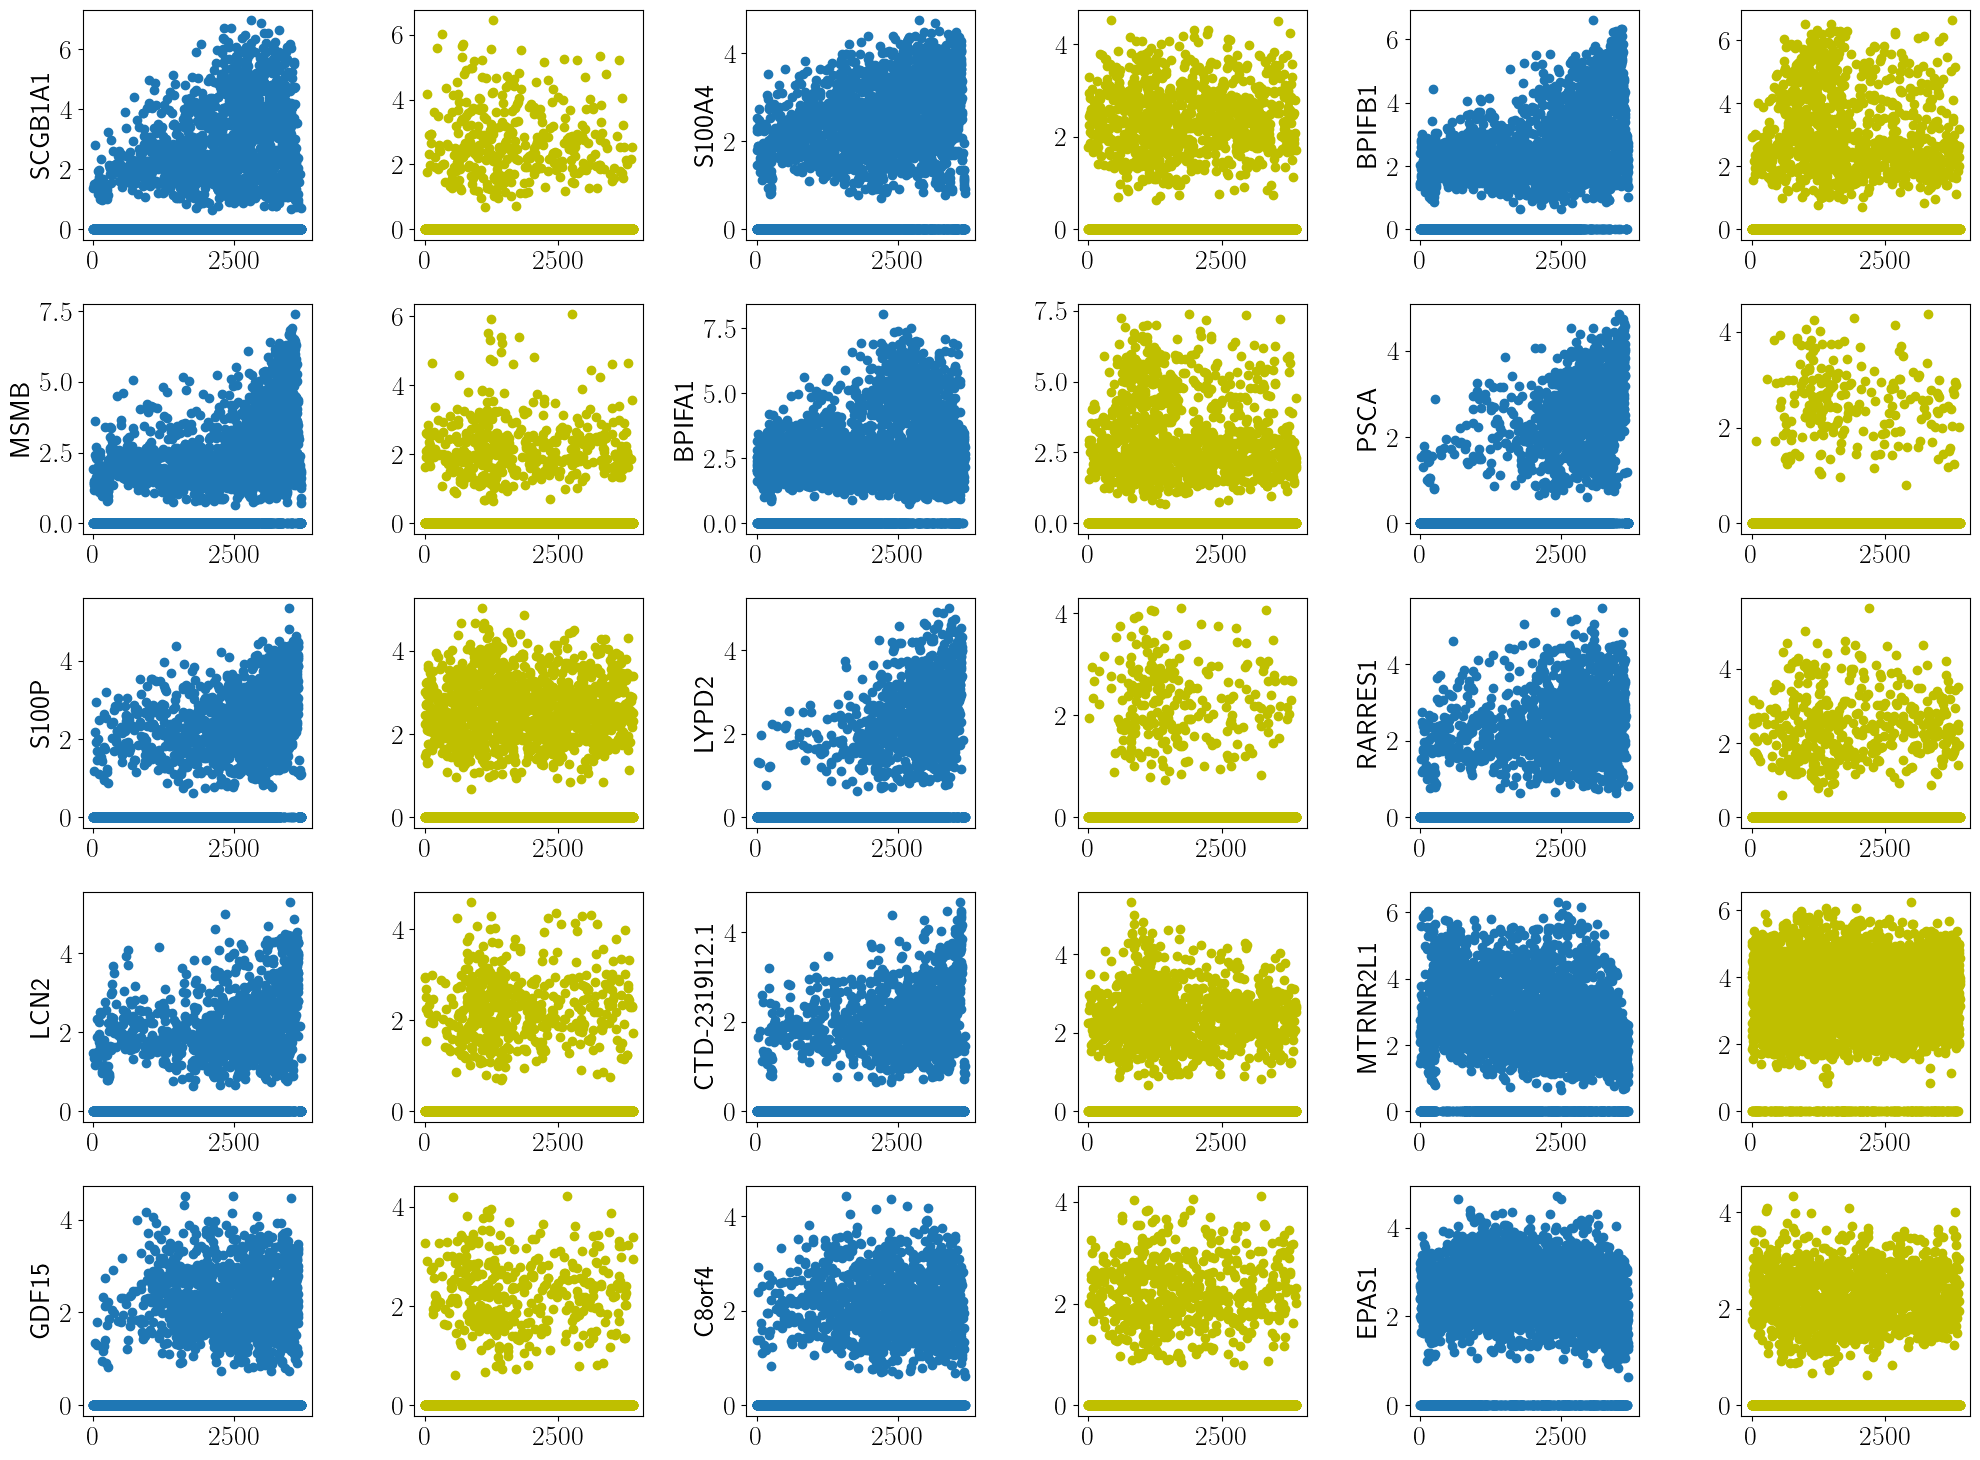

In [178]:
dim="Dim1"
plt.figure(figsize=(20,15))
for i in range(0,15):
    axs = plt.subplot(5,6,2*i+1)
    g=loading_w.loc[dim].sort_values(ascending=False).index[i]
    plotno = 2*i
    axs.scatter(no_polyp_order,foreground[:,list(adata.var_names).index(g)])
    axs.set_ylabel(g)
    axs = plt.subplot(5,6,2*i+2)
    axs.scatter(polyp_order,background[:,list(adata.var_names).index(g)],c="y")
    
plt.tight_layout()

In [21]:
preds_background = model.predict(background)
_, _, r2_contrastivereg_bg, _, _ = linregress(polyp_order.to_numpy().squeeze(), preds_background)


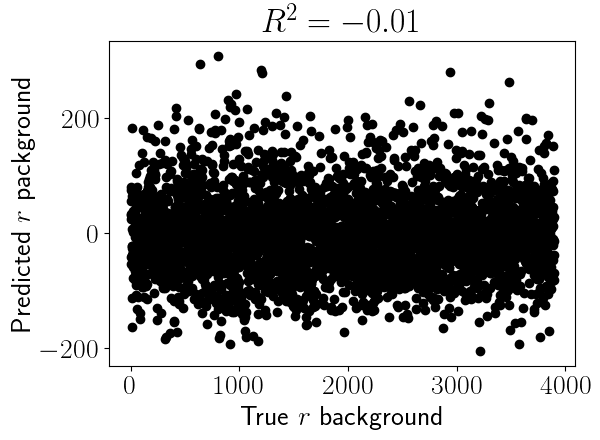

In [22]:
plt.scatter(polyp_order.to_numpy(),preds_background,c="black")
plt.xlabel(r"True $r$ background")
plt.ylabel(r"Predicted $r$ packground")
plt.title(r"$R^2 = " + str(round(r2_contrastivereg_bg, 2)) + "$")
plt.tight_layout()
plt.show()

In [9]:
df = pd.DataFrame(foreground, columns=adata.var_names)
df["pseudotime order"] = no_polyp_order[1].values
df["state"] = "foreground"
df_2 = pd.DataFrame(background, columns=adata.var_names)
df_2["pseudotime order"] = polyp_order[1].values
df_2["state"] = "background"

exp = pd.concat([df,df_2])

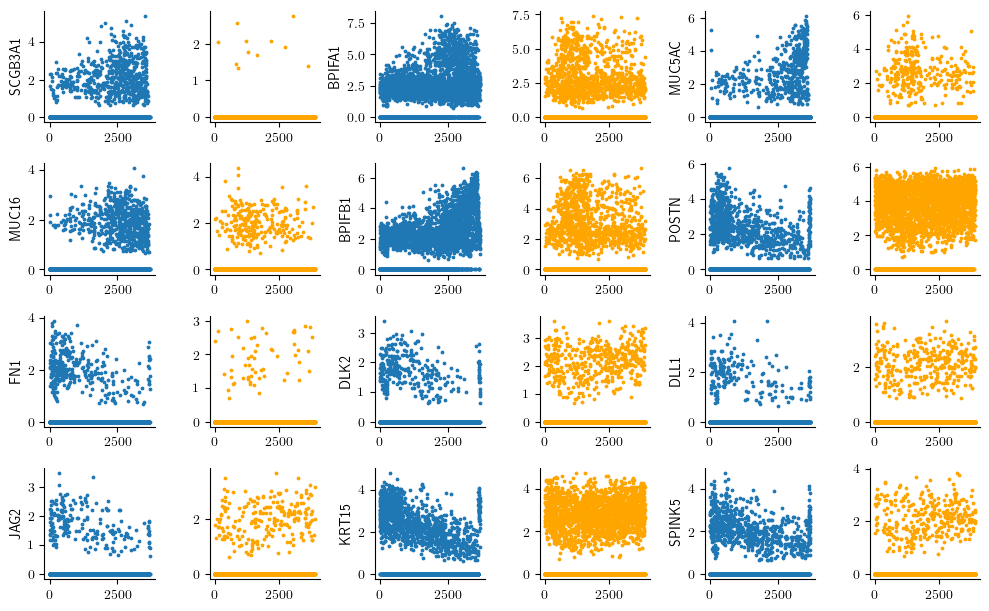

In [39]:
font = {"size": 10}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True
import seaborn as sns
plt.figure(figsize=(10,7.5))
for i,g in enumerate(["SCGB3A1","BPIFA1","MUC5AC","MUC16","BPIFB1","POSTN","FN1","DLK2","DLL1","JAG2","KRT15","SPINK5"]):
    axs = plt.subplot(5,6,2*i+1)
    plotno = 2*i
    axs.scatter(no_polyp_order,foreground[:,list(adata.var_names).index(g)],s=3)
    axs.set_ylabel(g)
    axs.spines[['right', 'top']].set_visible(False)
    axs = plt.subplot(5,6,2*i+2)
    axs.scatter(polyp_order,background[:,list(adata.var_names).index(g)],c="orange",s=3)
    axs.spines[['right', 'top']].set_visible(False)
#ax = sns.lmplot(x="pseudotime order",y="SCGB3A1",col="state",hue="state",data=exp)
#plt.savefig("SCGB3A1_expression.pdf",bbox_inches="tight")
plt.tight_layout(w_pad=.7)
plt.savefig("supplemental_polyp_genes_expression.pdf",bbox_inches="tight")


In [19]:
# compare multiple random seeds

st = time.time()
model_10 = LinearCRBZ()
model_10.fit(foreground, background, no_polyp_order.to_numpy(),d=3,verbose=False,print_every=1000000,seed=10)
preds_10 = model_10.predict(foreground)
et=time.time()
print("time elapsed "+str(et-st))

2024-07-02 15:26:25.965411: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  dot.14 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-07-02 15:26:27.295751: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2.330398717s
Constant folding an instruction is taking > 1s:

  dot.14 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessa

time elapsed 651.1040480136871


In [ ]:
st = time.time()
model_100 = LinearCRBZ()
model_100.fit(foreground, background, no_polyp_order.to_numpy(),d=3,verbose=False,print_every=1000000,seed=100)
preds_100 = model_100.predict(foreground)
et=time.time()
print("time elapsed "+str(et-st))

In [47]:
st = time.time()
model_150 = LinearCRBZ()
model_150.fit(foreground, background, no_polyp_order.to_numpy(),d=3,verbose=False,print_every=1000000,seed=150)
preds_150 = model_150.predict(foreground)
et=time.time()
print("time elapsed "+str(et-st))

time elapsed 636.8469140529633


In [48]:
betas_150 = pd.DataFrame(data=model_150.beta)

In [ ]:

betas_100 = pd.DataFrame(data=model_100.beta)

In [22]:
betas_10

,0
0,-7.357260
1,7.888663
2,18.833319


In [41]:
betas_100

,0
0,-15.104368
1,-13.603994
2,-11.902008


In [49]:
betas_150

,0
0,14.310707
1,16.167130
2,19.386011


In [50]:
dims = ["Dim%d" % i for i in range(0,3)]
loading_w_10 = pd.DataFrame(model_10.W, columns = adata.var_names, index = dims,dtype = "float")
loading_w_100 = pd.DataFrame(model_100.W, columns = adata.var_names, index = dims,dtype = "float")
loading_w_150 = pd.DataFrame(model_150.W, columns = adata.var_names, index = dims,dtype = "float")


In [32]:
genes_ranked_10 = pd.DataFrame(loading_w_10.loc["Dim2"].sort_values())
genes_ranked_10["rank"] = list(range(0,504))

In [45]:
genes_ranked_100 = pd.DataFrame(loading_w_100.loc["Dim0"].sort_values(ascending =False))# not ascending because this beta is negative 
genes_ranked_100["rank"] = list(range(0,504))

In [52]:
genes_ranked_150 = pd.DataFrame(loading_w_150.loc["Dim2"].sort_values())# not ascending because this beta is negative 
genes_ranked_150["rank"] = list(range(0,504))

In [59]:
genes_ranked_100.loc[genes_ranked_150.index]

,Dim0,rank
KRT15,-0.963582,496
POSTN,-0.562083,489
SPINK5,-0.561557,488
FN1,-0.230696,453
KAL1,-0.210504,447
...,...,...
RARRES1,-0.298456,470
BPIFA1,-1.673165,500
PSCA,-0.249426,459
SCGB1A1,-0.619601,490


In [61]:
genes_ranked_10

,Dim2,rank
KRT15,-0.083761,0
SPINK5,-0.055642,1
FN1,-0.041319,2
DLK2,-0.031330,3
NPPC,-0.022035,4
...,...,...
S100A4,1.311408,499
SCGB1A1,1.352976,500
MSMB,1.380603,501
BPIFA1,1.488957,502


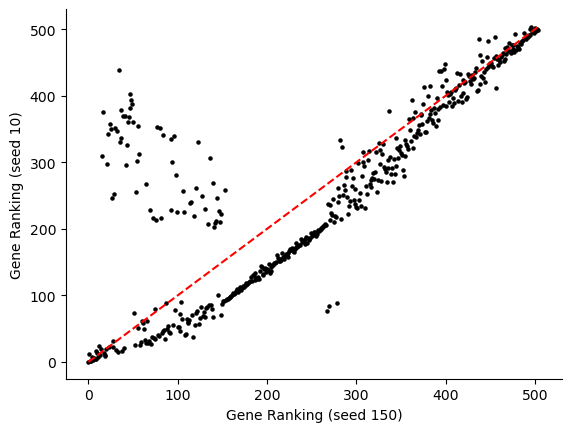

In [71]:
plt.scatter(genes_ranked_150["rank"],genes_ranked_10.loc[genes_ranked_150.index,"rank"],c="k",s=5)
plt.plot([0,505],[0,505],linestyle="dashed", color="red")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel("Gene Ranking (seed 10)")
plt.xlabel("Gene Ranking (seed 150)")
plt.savefig("random_seed_comparison.pdf")

In [11]:
# compare to linear regression
import time
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy.stats import linregress
R=no_polyp_order.to_numpy()
st = time.time()
linreg = LinearRegression()
pca = PCA(n_components=3)
X_reduced =pca.fit_transform(foreground)
linreg.fit(X_reduced, R)
et = time.time()
preds_linreg = linreg.predict(X_reduced)
_, _, r2_linreg, _, _ = linregress(R.squeeze(), preds_linreg.squeeze())
print("time elapsed "+str(et-st))

NameError: name 'no_polyp_order' is not defined

In [23]:
r2_linreg

0.7856928770946668

In [12]:
pca.

(3686, 3)

In [28]:
loading_pca = pd.DataFrame(pca.components_, columns = adata.var_names).T

In [29]:
loading_pca.sort_values(0)

,0,1,2
KRT15,-0.141299,0.103882,0.225469
POSTN,-0.106141,0.161948,0.189772
SPINK5,-0.066941,0.018682,0.120475
SULT1E1,-0.045777,-0.022856,0.016176
FN1,-0.035778,0.025884,0.040855
...,...,...,...
LYPD2,0.259985,-0.002653,-0.035923
S100P,0.260461,-0.063313,0.082678
SCGB1A1,0.280142,0.077890,-0.329269
MSMB,0.317462,0.036384,0.250038


In [40]:
loading_w=pd.read_csv("loadings_unscaled_d3.csv",index_col=0)

In [44]:
loading_w = loading_w.T

Text(0, 0.5, 'PCA rank')

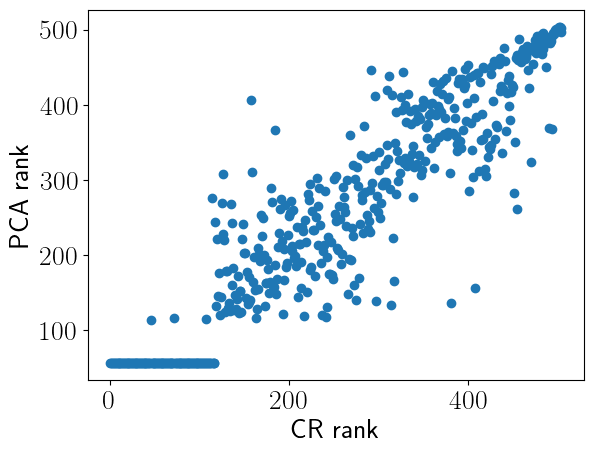

In [53]:
plt.scatter(loading_w["Dim1"].abs().rank(),loading_pca[0].abs().rank())
plt.xlabel("CR rank")
plt.ylabel("PCA rank")